# Midterm
#### leyu,lin(Jack) 817372912

[![]( https://img.shields.io/badge/Python-v3.7-orange)]()
[![](https://img.shields.io/badge/pandas-v1-blue)]()
[![](https://img.shields.io/badge/sklearn-v0.2-red)]()

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime
import os 
import glob
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Data File Paths

In [2]:
covid_confirmed_usafacts = 'covid_confirmed_usafacts.csv'
covid_county_population_usafacts = 'covid_county_population_usafacts.csv'
covid_deaths_usafacts = 'covid_deaths_usafacts.csv'

name_path = 'names'

### Create Panda DataFrame

In [3]:
df_case = pd.read_csv(covid_confirmed_usafacts)
df_population = pd.read_csv(covid_county_population_usafacts)
df_deaths = pd.read_csv(covid_deaths_usafacts)

## Questions

#### 1. Compute the total confirmed cases per day in the country. Produce a table and a line plot.

In [4]:
# select columns need to sum up
all_cases = df_case[[col for col in df_case.columns if '2020' in col]].copy()

# sum up columns
all_cases.loc['total_case'] = all_cases.apply(lambda x: x.sum())

,date,total_cases
0,1/22/2020,1
1,1/23/2020,1
2,1/24/2020,2
3,1/25/2020,2
4,1/26/2020,5
...,...,...
71,4/2/2020,241643
72,4/3/2020,276889
73,4/4/2020,310597
74,4/5/2020,335338


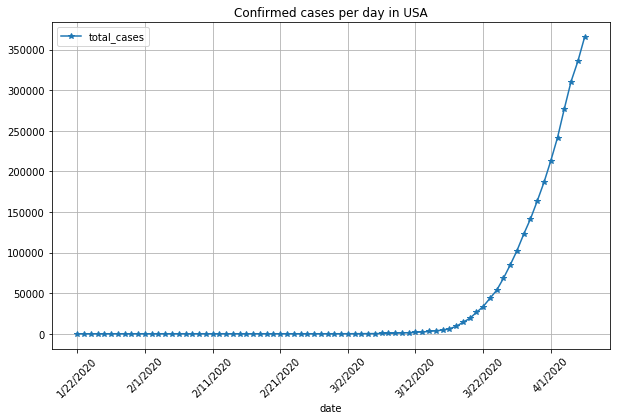

In [5]:
#display result
df_q1= all_cases.iloc[-1:]

#create new table with date and cases
df_q1 = df_q1.stack().reset_index(-1).iloc[:, ::-1]
df_q1.columns = ['total_cases', 'date']

#line plot
df_q1.plot(x='date', y='total_cases',rot=45,
                title='Confirmed cases per day in USA',
                grid=True,
                style='*-',
                figsize=(10,6))

df_q1 = df_q1[['date','total_cases']]
df_q1.reset_index(drop=True, inplace=True)
df_q1

#### 2. Compute the total confirmed cases per week in the country. Produce a table of results. Plot the results using a log line plot. That is the log of the number of cases. A log plot of an exponential process will produce a straight line. Does the resulting plot look like an exponential?

,weeks,total_cases
0,4,5
1,5,9
2,6,11
3,7,13
4,8,15
5,9,30
6,10,477
7,11,3643
8,12,33469
9,13,141409


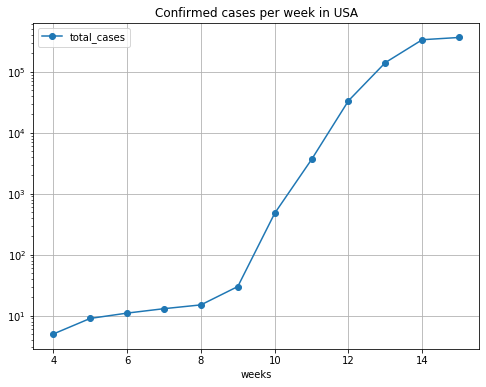

In [6]:
dt_date =  pd.to_datetime(df_q1['date'])
dt_weeks = dt_date.dt.week

#get total case per weeks by take max of each week
df_cases_weeks = df_q1.groupby(dt_weeks)['total_cases'].max().reset_index()
cases_weeks = df_cases_weeks.rename(columns={'date':'weeks'})

cases_weeks.plot(x='weeks', y='total_cases',
                title='Confirmed cases per week in USA',
                logy=True,
                grid=True,
                style='o-',
                figsize=(8,6))

cases_weeks

### Does the resulting plot look like an exponential?
* The results seems partial exponential, from above fig can tell from week 9 to 14 almost a staright line. There was tremendous increasing from week 9 to week 14

#### 3. Compute the number of new confirmed cases per week in the the country. Produce a table of results.

In [7]:
# compute new cases use last week subtract previous week
list_new_case = []
list_week =[]
for i in range(len('total_cases')):
    val = cases_weeks.loc[i+1] - cases_weeks.loc[i]
    period = (cases_weeks['weeks'].loc[i],cases_weeks['weeks'].loc[i+1])  
    list_new_case.append(val)
    list_week.append(period)
df_new_case = pd.DataFrame(list_new_case)
df_period = pd.DataFrame(list_week)
df_new_case= pd.concat([df_new_case, df_period], axis=1)

df_new_case.columns =['period',
                      'new_cases',
                      'previous_week',
                      'next_week']

df_new_case[['previous_week','next_week','period','new_cases']]

,previous_week,next_week,period,new_cases
0,4,5,1,4
1,5,6,1,2
2,6,7,1,2
3,7,8,1,2
4,8,9,1,15
5,9,10,1,447
6,10,11,1,3166
7,11,12,1,29826
8,12,13,1,107940
9,13,14,1,193929


#### 4. Repeat #2 with the number of known deaths.

,weeks,known_deaths
5,9,1.0
6,10,22.0
7,11,68.0
8,12,416.0
9,13,2458.0
10,14,9547.0
11,15,10848.0


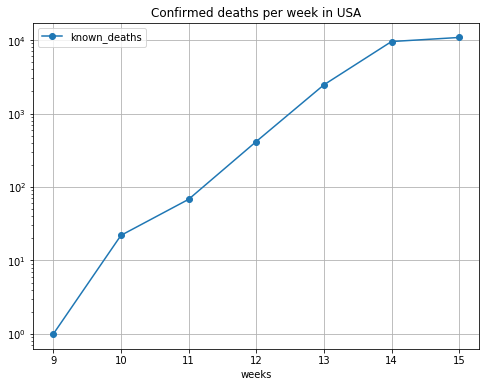

In [8]:
# count deaths cases for each day 
day_deaths = df_deaths[[col for col in df_deaths.columns if '2020' in col]].copy()
day_deaths.loc['total_deaths'] = day_deaths.apply(lambda x: x.sum())

#similar to question 1 and question 2
day_deaths= day_deaths.iloc[-1:]
day_deaths = day_deaths.stack().reset_index(-1).iloc[:, ::-1]
day_deaths.columns = ['known_deaths', 'date']

# count deaths per week
dt_date =  pd.to_datetime(day_deaths['date'])
dt_weeks = dt_date.dt.week
df_deaths_weeks = day_deaths.groupby(dt_weeks)['known_deaths'].max().reset_index()
deaths_weeks = df_deaths_weeks.rename(columns={'date':'weeks'})

# pick death is 'known' or greater than 0
deaths_weeks = deaths_weeks[deaths_weeks['known_deaths'] > 0]

# line plot
deaths_weeks.plot(x='weeks', y='known_deaths',
                title='Confirmed deaths per week in USA',
                logy=True,
                grid=True,
                style='o-',
                figsize=(8,6))

deaths_weeks

### Does the resulting plot look like an exponential?
* The results seems almost exponential, from above fig can tell from week 10 to 14 is a staright line. There was tremendous increasing from week 10 to week 14

#### 5. Find the 10 counties with the most known number of covid-19 cases. Plot the number of cases each week. What are the differences or similarities?

In [9]:
# select columns need to compare
counties_cases = df_case[[col for col in df_case.columns if '2020' in col]]

# find out total cases by counties
df_case['counties_cases'] = counties_cases.apply(lambda x: x.max(), axis =1)
df_counties_cases = df_case.groupby(['County Name','State'])[
                                'counties_cases'].sum().reset_index()

# show most 10 cases of counties, filter out 'unknown counties'
df_most10_counties = df_counties_cases[df_counties_cases['County Name']
                              .str.contains('County')].nlargest(10,'counties_cases')
df_most10_counties


,County Name,State,counties_cases
2368,Queens County,NY,23133
1509,Kings County,NY,19702
2043,Nassau County,NY,15616
275,Bronx County,NY,14327
3075,Westchester County,NY,14294
2766,Suffolk County,NY,13487
2065,New York County,NY,10440
629,Cook County,IL,8728
3046,Wayne County,MI,8270
189,Bergen County,NJ,6862


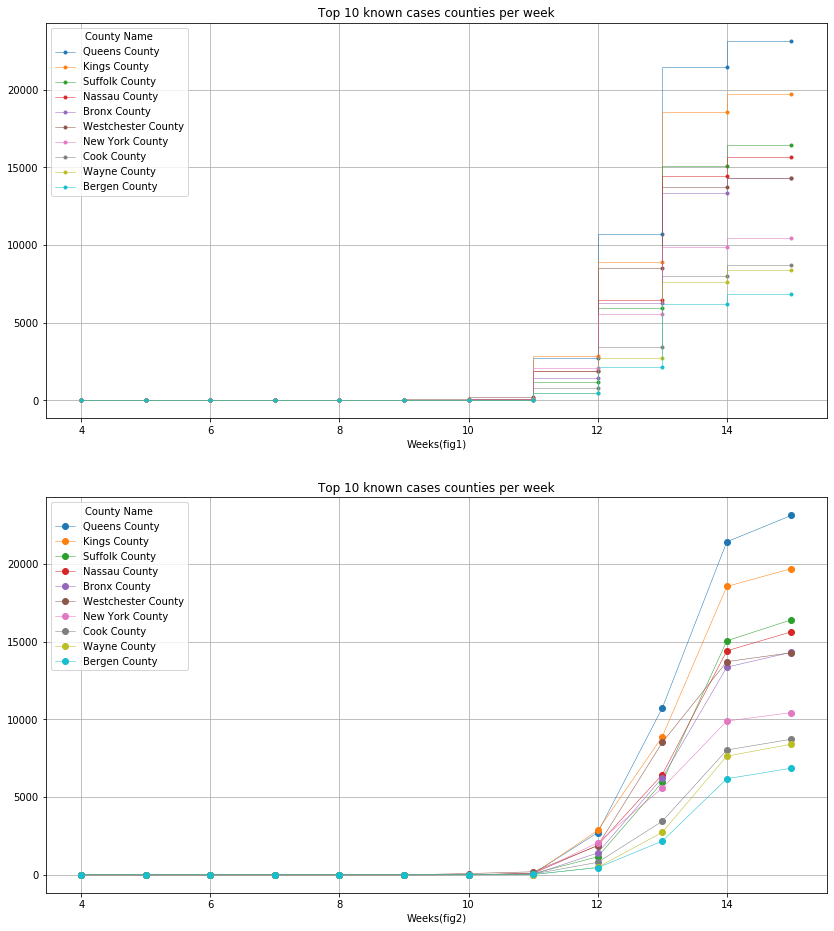

In [10]:
df_counties = df_case.groupby('County Name').sum().reset_index()
df_top10_counties = df_counties[df_counties['County Name']
                               .str.contains('County')].nlargest(10,'counties_cases')

#transpose and extract week to create better table
df_top10_T = df_top10_counties.iloc[:,3:-1].T
dt_index = pd.to_datetime(df_top10_T.index)
df_top10_T.index = dt_index.week
df_top10_T

df_week_deaths = df_top10_T.groupby(df_top10_T.index).max()
# assign column names
df_week_deaths.columns = df_top10_counties['County Name']

fig, axes = plt.subplots(nrows=2, ncols=1)
#line plot
ax1 = df_week_deaths.plot(title='Top 10 known cases counties per week',
                         figsize=(14,16),
                         style='.-',
                         drawstyle="steps",
                         ax=axes[0],
                         grid=True,
                         linewidth=0.5)

ax2 = df_week_deaths.plot(title='Top 10 known cases counties per week',
                         figsize=(14,16), 
                         style='o-',
                         ax=axes[1],
                         grid=True,
                         linewidth=0.5)
ax1.set_xlabel("Weeks(fig1)")
ax2.set_xlabel("Weeks(fig2)")
plt.show()

* ### Differences 
    * NY and seattle (Queens county/ Kings County) has tremendous increased after week 13 from fig 1
* ### Similarities
    * all counties Covid cases was growing start at week 10 both fig 1 and 2
    * before weeks 10 there was most unknown (Incubation period likely 4-9 weeks)
    * the density is very high during week 11 to week 12 from figh 1

#### 6. Compute the number of known cases per population in each county that have cases ofcovid-19. Produce a bar graph and table of the results for the 10 counties with the highest values and the 10 counties with the lowest values.

In [11]:
# merge population and case dataframe
df_case_ppl= pd.concat([df_case, df_population['population']], axis=1)

# select row need to sum up
rows_county = df_case_ppl[[col for col in df_case.columns if '2020' in col]]

# sum up all period get total cases
df_case_ppl['county_cases'] = rows_county.apply(lambda x: x.max(), axis =1)

# sum up population and cases by county
df_total_case = df_case_ppl.groupby(['County Name','State'])[
                                'county_cases'].sum().reset_index()
df_total_population = df_case_ppl.groupby(['County Name','State'])[
                              'population'].sum().reset_index()
df_tc_population = pd.concat([df_total_case,
                              df_total_population['population']],
                              axis=1)

#take out unknown counties
df_tc_population = df_tc_population[df_tc_population['County Name']
                              .str.contains('County')]

# select population is above 0 consider  as "known"
# select cases is above 0 consider  as "known"
df_tc_population = df_tc_population[
                   df_tc_population['population'] > 0]
df_tc_population = df_tc_population[
                   df_tc_population['county_cases'] > 0]

# calculate cases per population
df_tc_population['case_per_population'] =\
                df_tc_population['county_cases']/df_tc_population['population']* 100000

,County Name,State,county_cases,population,case_per_population
211,Blaine County,ID,423,23021,1837.452761
2456,Rockland County,NY,5703,325789,1750.519508
3075,Westchester County,NY,14294,967506,1477.406858
2043,Nassau County,NY,15616,1356924,1150.838219
2368,Queens County,NY,23133,2253858,1026.373445
275,Bronx County,NY,14327,1418207,1010.219242
2425,Richmond County,NY,4579,476143,961.685880
2766,Suffolk County,NY,13487,1476601,913.381475
2145,Orange County,NY,3397,384940,882.475191
805,Dougherty County,GA,722,87956,820.864978


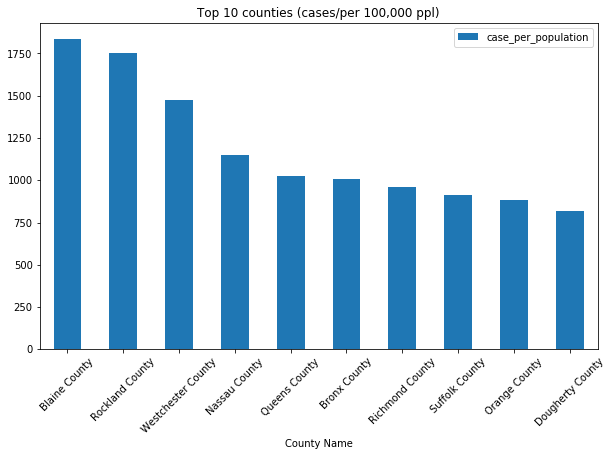

In [12]:
#   10 highest values counties
df_top10 = df_tc_population.nlargest(10,'case_per_population')

# bar plot
df_top10.plot.bar(x='County Name', y='case_per_population', 
                  rot=45, title='Top 10 counties (cases/per 100,000 ppl)',
                  figsize=(10,6))
df_top10

,County Name,State,county_cases,population,case_per_population
1241,Henderson County,TX,1,82737,1.208649
2546,Scioto County,OH,1,75314,1.327774
85,Aroostook County,ME,1,67055,1.491313
2822,Tehama County,CA,1,65084,1.536476
1599,Laurel County,KY,1,60813,1.644385
2267,Pike County,KY,1,57876,1.727832
62,Anderson County,TX,1,57735,1.732052
1194,Hardin County,KY,2,110958,1.802484
2885,Tuolumne County,CA,1,54478,1.835603
1614,Le Flore County,OK,1,49853,2.005897


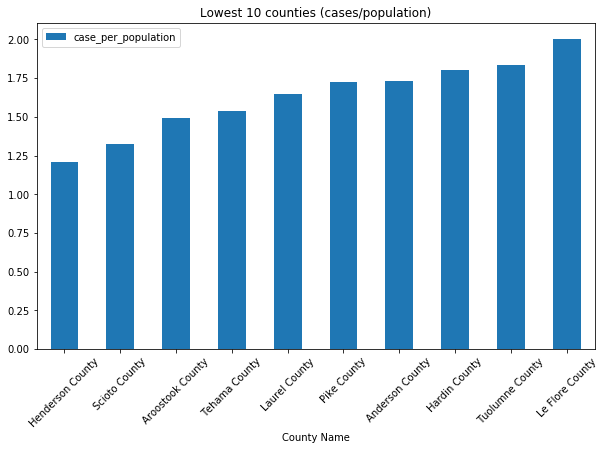

In [13]:
# 10 lowest values counties
df_min10 = df_tc_population.nsmallest(10,'case_per_population')

# bar plot
df_min10.plot.bar(x='County Name', y='case_per_population', 
                  rot=45, title='Lowest 10 counties (cases/population)',
                  figsize=(10,6))
df_min10

#### 7. Compute the death rate (deaths/ known cases) in each county that have both deaths and known cases. Compute the mean and standard deviation of the results.
* The death case in data some rows was decrease
* I filter out invalid value e.g below 0
* I filter out county that is unknown

In [14]:
# count deaths cases for each county  similar to previous question
all_deaths = df_deaths[[col for col in df_deaths.columns if '2020' in col]]
df_deaths['county_deaths'] = all_deaths.apply(lambda x: x.max(), axis =1)
df_total_deaths = df_deaths.groupby(['County Name','State'])[
                                'county_deaths'].sum().reset_index()

# merge deaths and cases dataframe and pick death cases greater than 0
df_case_death= pd.concat([df_counties_cases, df_total_deaths['county_deaths']], axis=1)
df_case_death = df_case_death[df_case_death['counties_cases'] > 0]


#take out unknown counties
df_case_death = df_case_death[df_case_death['County Name']
                              .str.contains('County')]

#calculate death rate
df_case_death['deaths_rate'] =  df_case_death['county_deaths']/ df_case_death['counties_cases']

df_case_death

,County Name,State,counties_cases,county_deaths,deaths_rate
0,Abbeville County,SC,6,0.0,0.00000
2,Accomack County,VA,11,0.0,0.00000
3,Ada County,ID,419,3.0,0.00716
4,Adair County,IA,1,0.0,0.00000
5,Adair County,KY,1,0.0,0.00000
...,...,...,...,...,...
3187,Young County,TX,3,0.0,0.00000
3188,Yuba County,CA,11,0.0,0.00000
3190,Yuma County,AZ,13,0.0,0.00000
3191,Yuma County,CO,2,0.0,0.00000


In [15]:
#mean stdev of result
df_stdev = df_case_death.iloc[:,2:].std().to_frame()
df_mean = df_case_death.iloc[:,2:].mean().to_frame()
df_stdev.columns = ['standard deviation']
df_mean.columns = ['mean']
df_mean_stdev = df_stdev.join(df_mean)

# add min/max for each row
df_mean_stdev['max'] = [df_case_death['counties_cases'].max(),
                        df_case_death['county_deaths'].max(),
                        df_case_death['deaths_rate'].max()]
df_mean_stdev['min'] = [df_case_death['counties_cases'].min(),
                        df_case_death['county_deaths'].min(),
                        df_case_death['deaths_rate'].min()]
# add number of valid counties counted

print('After filtered Num of counties:',df_case_death['County Name'].count())
df_mean_stdev.iloc[:,::-1]

After filtered Num of counties: 2353


,min,max,mean,standard deviation
counties_cases,1.0,23133.0,144.634934,1005.587106
county_deaths,0.0,1022.0,4.097748,37.776956
deaths_rate,0.0,3.0,0.026354,0.103597


#### 8. Produce a violin plot of the death rates found in #7
* I filted death rate above 1 because deaths/known cases. All cases could be death cases, but cant go beyond
* ppl dead more than ppl you know which not make sense

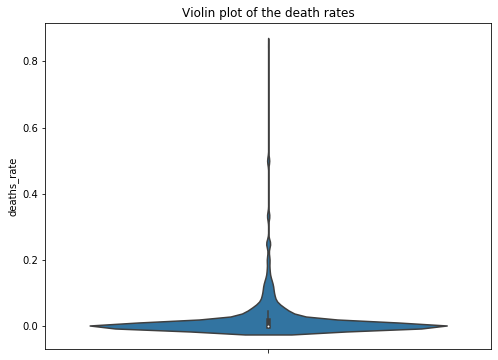

In [16]:
#filter unreason data
filtered_deaths = df_case_death[df_case_death['deaths_rate'] < 1]

plt.subplots(figsize=(8,6))
plt.title('Violin plot of the death rates')
sns.violinplot(y = filtered_deaths['deaths_rate'])
plt.show()

#### 9. There is some hope that covid-19 may have peaked in NYC (counties Bronx, Kings, New York, Queens and Richmond). Is there any evidence of that in the data?

In [17]:
# count all known cases of all counties in NYC 
df_counties_cases = df_case.groupby(['County Name','State'])[
                                'counties_cases'].sum().reset_index()
df_top_NYC = df_counties_cases[df_counties_cases['State'].str.contains('NY') ]
df_top_NYC = df_top_NYC.nlargest(15,'counties_cases')

#highligh name we need
df_top_NYC.style.apply(lambda x: ['background: lightgreen' 
                                  if (x['County Name'] == 'Bronx County' 
                                      or x['County Name'] == 'Kings County' 
                                      or x['County Name'] == 'New York County'
                                      or x['County Name'] == 'Queens County'
                                      or x['County Name'] == 'Richmond County')
                                  else '' for i in x], axis=1)

,County Name,State,counties_cases
2368,Queens County,NY,23133
1509,Kings County,NY,19702
2043,Nassau County,NY,15616
275,Bronx County,NY,14327
3075,Westchester County,NY,14294
2766,Suffolk County,NY,13487
2065,New York County,NY,10440
2456,Rockland County,NY,5703
2425,Richmond County,NY,4579
2145,Orange County,NY,3397


* Clearly, from highlight above Queens County is the peak. Then Kings County
But Bronx, New York,Richmond was not even top 3.

#### 10.Seattle (King county in Washington) also hopes that they have peaked. Is there any evidence of that in the data?

In [18]:
# count all cases of all counties in Washington 
df_top_WA = df_counties_cases[df_counties_cases['State'].str.contains('WA') ]
df_top_WA = df_top_WA.nlargest(15,'counties_cases')

#highligh name we need
df_top_WA.style.apply(lambda x: ['background: lightgreen' 
                                  if (x['County Name'] == 'King County')
                                  else '' for i in x], axis=1)

,County Name,State,counties_cases
1502,King County,WA,3295
2629,Snohomish County,WA,1522
2731,Statewide Unallocated,WA,1216
2260,Pierce County,WA,590
3168,Yakima County,WA,346
2646,Spokane County,WA,203
3082,Whatcom County,WA,183
187,Benton County,WA,172
2620,Skagit County,WA,162
531,Clark County,WA,154


* Clearly, from highlight above King County is the peak (Seattle).

## Names

#### 1. Combine the files into one dataframe that contains year, name, sex and number of peopleborn that year. Create a training set and a test set from this dataframe.

In [19]:
# combine files slice the year add to columns
txt_list = []
files = glob.glob(name_path + "/*.txt")

for file in files:
    year = year = os.path.basename(file)[3:7]
    txt_list.append(pd.read_csv(file, header=None).assign(year=year))

df_comb = pd.concat(txt_list, ignore_index=True)
df_comb.to_csv("name.csv", header=False, index=False)

#### Name file path.

In [20]:
name_csv = 'name.csv'
df_name = pd.read_csv(name_csv)

In [21]:
df_name = pd.DataFrame(np.vstack([df_name.columns, df_name]))

#### Data Checking

In [22]:
df_name.columns=['name','sex','births','year']
df_name.head(10)

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
5,Margaret,F,1578,1880
6,Ida,F,1472,1880
7,Alice,F,1414,1880
8,Bertha,F,1320,1880
9,Sarah,F,1288,1880


In [23]:
df_name.size

7828184

In [24]:
df_name.dtypes

name      object
sex       object
births    object
year      object
dtype: object

In [25]:
df_name.isnull().isnull().sum()

name      0
sex       0
births    0
year      0
dtype: int64

In [26]:
#change types and convert sex to 0 or 1
df_name['year'] = pd.to_numeric(df_name['year'])
df_name['births'] = pd.to_numeric(df_name['births'])
df_name.sex.replace({'F':0,'M':1}, inplace=True)

In [27]:
#convert name object to numerical values
df_name['name'] = LabelEncoder().fit_transform(df_name['name'].values)
df_name

,name,sex,births,year
0,61717,0,7065,1880
1,6272,0,2604,1880
2,28345,0,2003,1880
3,27550,0,1939,1880
4,64522,0,1746,1880
...,...,...,...,...
1957041,98291,1,5,2018
1957042,98360,1,5,2018
1957043,98375,1,5,2018
1957044,98382,1,5,2018


In [28]:
# group by name and sex and year count the raito of birth
df_name['name_ratio'] = df_name.births / df_name.births.sum()
df_name

,name,sex,births,year,name_ratio
0,61717,0,7065,1880,2.009083e-05
1,6272,0,2604,1880,7.405027e-06
2,28345,0,2003,1880,5.695956e-06
3,27550,0,1939,1880,5.513958e-06
4,64522,0,1746,1880,4.965122e-06
...,...,...,...,...,...
1957041,98291,1,5,2018,1.421856e-08
1957042,98360,1,5,2018,1.421856e-08
1957043,98375,1,5,2018,1.421856e-08
1957044,98382,1,5,2018,1.421856e-08


#### create traning and testing set

In [29]:
#convert object to features
X = df_name[['name','births','year']] # feature 1,2,3
Y = df_name['sex']  # label

#Obersvation assignment 33% to testing set. 67% for tranning set 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state = 0)

#### 2. For the first model determine for each name which sex used the name most in the training data. How good is the model on the test set? How to measure good?

In [30]:
count = pd.DataFrame({'name': X_test['name'], 
                      'sex': y_test}).groupby(['name', 'sex'])['name']\
                                     .count()
#  count most sex determine name
def first_model(name, count):
    if (name,0) in count:
        female_count = count[(name, 0)]
    else:
        female_count = 0
    if (name,1) in count:
        male_count = count[(name, 1)]
    else:
        male_count = 0
    if female_count > male_count:
        return 0 
    else:
        return 1 

####  By mearse how good or the fitness. 
* use 33% test_set get response in this case is  660k columns out  of 2000k  
* compare with actual value in y test get the accuracy
* could try more different  test sizes  from 20 to 40 

In [31]:
x_test_result = pd.Series(X_test['name']).apply(lambda x: first_model(x, count))
model_test_score = accuracy_score(y_test, x_test_result)
print('accuracy of model1 test:',model_test_score*100,'%')

accuracy of model1 test: 90.80634722045876 %


#### 3. For the second model create a decision tree using the training data. How good is the model on the test set?

In [32]:
# use sklearn descision tree train model
second_model = tree.DecisionTreeClassifier()
second_model.fit(X_train,y_train)
print('accuracy of model2 test:',second_model.score(X_test,y_test)*100,'%')
print('accuracy of model2 train:',second_model.score(X_train,y_train)*100,'%')

accuracy of model2 test: 93.24431038700827 %
accuracy of model2 train: 99.88651789936091 %


#### 4. How do the two models compare?

* from above question we can see second model has better accuracy or fitness to actual value in y_test
* decision tree has considered year may affect people's choices, there are may be a trend along the year

In [33]:
# further compare
# take top 1000 data for comparsion
X = df_name[['name','births','year']].head(1000)
Y = df_name['sex'].head(1000)

#assign differ test size. try 38% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.38, shuffle=True)

In [34]:
x_test_result = pd.Series(X_test['name']).apply(lambda x: first_model(x, count))
model_test_score = accuracy_score(y_test, x_test_result)
print('accuracy of model1 test:',model_test_score*100,'%')

accuracy of model1 test: 91.57894736842105 %


In [35]:
second_model = tree.DecisionTreeClassifier()
second_model.fit(X_train,y_train)
print('accuracy of model2 test:',second_model.score(X_test,y_test)*100,'%')

accuracy of model2 test: 94.47368421052632 %


* reduce features take out year

In [65]:
X = df_name[['name','births']].head(1000)
Y = df_name['sex'].head(1000)

#assign differ test size. try 38% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.38, shuffle=True)

In [66]:
x_test_result = pd.Series(X_test['name']).apply(lambda x: first_model(x, count))
model_test_score = accuracy_score(y_test, x_test_result)
print('accuracy of model1:',model_test_score*100,'%')

accuracy of model1: 93.15789473684211 %


In [67]:
second_model = tree.DecisionTreeClassifier()
second_model.fit(X_train,y_train)
print('accuracy of model2 without year:',second_model.score(X_test,y_test)*100,'%')

accuracy of model2 without year: 93.42105263157895 %


* The result getting close without year, It seems year was take role of accuracy
* Second model is best choice in this case